<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminary/Seminary_UGent_oct_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

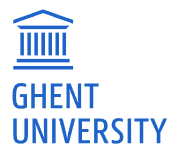<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
October 25, 2023<br>
Andy Louwyck

---



---

# **AXISYMMETRIC FLOW IN MULTILAYER AQUIFER SYSTEMS**

This notebook contains some code examples that illustrate the models discussed in the presentation. The explanation provided with each example is relatively concise. If you want to get a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed models, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 74 (delta 4), reused 0 (delta 0), pack-reused 60
Receiving objects: 100% (74/74), 101.09 KiB | 536.00 KiB/s, done.
Resolving deltas: 100% (38/38), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package contains most of the analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). However, keep in mind it is work in progress! The ultimate goal is to release it as a full-fledged package that can be installed using PIP.

Importing module `inspect` will allow us to print the source code of the functions implemented in the `maxsypy` package:

In [3]:
import inspect

## 1. The Thiem-Dupuit equations

The Thiem equation is used to calculate steady-state *confined* one-dimensional axisymmetric flow to a pumping well, while the Dupuit equation is used to calculate steady-state *unconfined* one-dimensional axisymmetric flow to a pumping well.

We import functions `thiem` and `dupuit` from module `maxsypy.special`:

In [4]:
from maxsypy.special import thiem, dupuit

Printing the source code of these functions:

In [5]:
print(inspect.getsource(thiem))

def thiem(r, T, Q, r_out, h_out=0.0):
    """
    Calculate hydraulic head at given distances r according to the Thiem formula for steady confined flow.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `r_out`.
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
        Pumping rate [L³/T] of the well.
    r_out : float
          Radial distance [L] of the outer aquifer boundary.
    h_out : float, default: 0.0
          Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    r = np.array(r)
    return h_out + Q / 2 / np.pi / T * np.log(r_out / r)



In [6]:
print(inspect.getsource(dupuit))

def dupuit(r, K, h0, Q, r_out):
    """
    Calculate hydraulic head at given distances r according to the Dupuit formula for steady unconfined flow.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `r_out`.
    K : float
      Aquifer conductivity [L/T].
    h0 : float
       Initial hydraulic head [L] which is the initial aquifer thickness before pumping.
       `h0` is also the constant head at the outer aquifer boundary at distance `r_out`.
    Q : float
      Pumping rate [L³/T] of the well (which is negative in case of extraction).
    r_out : float
          Radial distance [L] of the outer aquifer boundary.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.
    """
    return np.sqrt(h0**2 + Q / np.pi / K * np.log(r_out / r))



Note that pumping rate `Q` is *negative* in case of pumping! The derivations in the presentation assume `Q` is positive if water is extracted from the aquifer.

An example to illustrate the use of these functions:

In [7]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
R  = 500     # radius of influence (m)
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)

r = np.logspace(-2, np.log10(R), 100)         # radial distances (m)
h1 = dupuit(r=r, Q=Q, K=K, r_out=R, h0=h0)    # head (m) according to the Dupuit formula
h2 = thiem(r=r, Q=Q, T=T, r_out=R, h_out=h0)  # head (m) according to the Thiem formula

The corresponding plot:

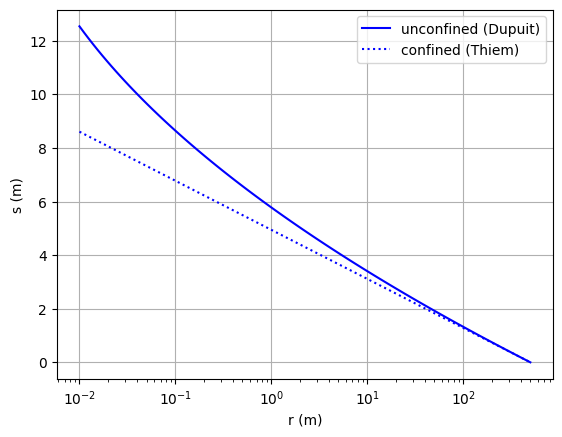

In [8]:
plt.semilogx(r, h0 - h1, 'b-', label='unconfined (Dupuit)');  # drawdown s (m) according to the Dupuit formula
plt.semilogx(r, h0 - h2, 'b:', label='confined (Thiem)');     # drawdown s (m) according to the Thiem formula
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.legend();
plt.grid();

Although previous semi-logarithmic graph is more practical, it's also possible to visualize the actual cone of depression:

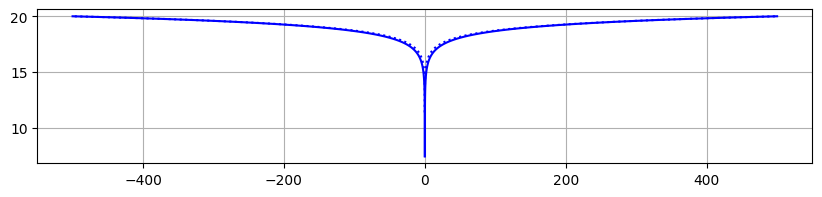

In [9]:
plt.figure(figsize=(10, 2));
plt.plot(-r, h1, 'b-');
plt.plot(r, h1, 'b-');
plt.plot(-r, h2, 'b:');
plt.plot(r, h2, 'b:');
plt.grid();

## 2. The Sichardt formula

The Sichardt is an empirical formula to estimate the radius of influence $R$:

> $R = 3000 s_w \sqrt{K}$

with $s_w$ the drawdown (m) in the pumping well and $K$ the aquifer conductivity (m/s). Usually, the calculated radius of influence is introduced in the Thiem or the Dupuit equation to estimate the pumping rate $Q$ that is required to obtain drawdown $s_w$ in the well.

Here, we'll combine the Sichardt formula with the Thiem-Dupuit equations to simulate the cone of depression when $Q$ is given, which is a bit more challenging.

Let's get back to the previous example to illustrate this:

In [10]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
R  = 500     # radius of influence (m)
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
rw = 0.1     # well-radius (m)

We define the empirical Sichardt formula as a function `sichardt` using `lambda`:

In [11]:
sichardt = lambda K, sw: 3000 * sw * np.sqrt(K / 24 / 3600)

Note that conductivity `K` must be expressed in m/s instead of m/d!!

Let's calculate the radius of influence according to the Sichardt formula when the Dupuit and the Thiem equations are applied:

In [12]:
# Dupuit
sw = h0 - dupuit(r=rw, K=K, h0=h0, Q=Q, r_out=R)  # drawdown (m) in the well
sichardt(K, sw)  # radius (m) of influence according to Sichardt

279.08255651720174

In [13]:
# Thiem
sw = h0 - thiem(r=rw, T=T, Q=Q, r_out=R, h_out=h0)  # drawdown (m) in the well
sichardt(K, sw)  # radius (m) of influence according to Sichardt

218.75148892163827

The problem is that the Dupuit and Thiem equations return a different drawdown `sw` in the well. For instance, check the Thiem result:

In [14]:
# drawdown sw introduced the Sichardt formule
print(sw)
# drawdown sw according to the Thiem equation using R according to Sichardt
print(h0 - thiem(r=rw, T=T, Q=Q, r_out=sichardt(K, sw), h_out=h0))

6.777766988412651
6.119922498481639


We need to find a value for `R` that gives the same result! Mathematically, we need to find the intersect of the two equations. To illustrate this, let's plot drawdown in the well `sw` as a function of radius of influence `R`. To do that, we need to rearrange the Sichardt equation as follows:

> $s_w = \dfrac{R}{3000\sqrt{K}}$

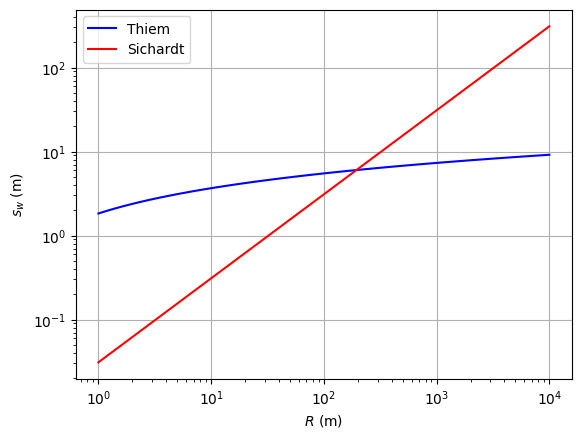

In [15]:
R = np.logspace(0, 4, 100)  # values for R
sw1 = [h0 - thiem(r=rw, T=T, Q=Q, r_out=R, h_out=h0) for R in R]  # sw according to Thiem
sw2 = [R / 3000 / np.sqrt(K / 24 / 3600) for R in R]  # sw according to Sichardt

plt.loglog(R, sw1, 'b-', R, sw2, 'r-');
plt.legend(['Thiem', 'Sichardt']);
plt.xlabel('$R$ (m)');
plt.ylabel('$s_w$ (m)')
plt.grid();

It's difficult to see the value of `R` that corresponds to the point where the two curves intersect. Fortunately, it is possible to find that value by applying an iterative solver. First, we define a function that calculates the difference between a given value for `R` and the value calculated by the Sichardt formula:

In [16]:
def func(logR):
    # logR = log10(R)
    sw = h0 - thiem(r=rw, T=T, Q=Q, h_out=h0, r_out=10**logR)
    R = sichardt(K=K, sw=sw)
    return R - 10**logR

Note that the given value is log-transformed. That's not required, but it avoids negative values for `R`.

Now it is possible to apply Scipy function `root_scalar` from module `scipy.optimize` that finds the root of a scalar function. In this case, it will find the root of function `func`, which corresponds to the case where the given value for `R` and the calculated value according to Sichardt are the same!

In [17]:
from scipy.optimize import root_scalar

result = root_scalar(func, x0=2)  # x0 is initial guess for logR
print(result)
R_sich = 10**result.root
print('R:', R_sich)

      converged: True
           flag: converged
 function_calls: 12
     iterations: 6
           root: 2.288924053159003
R: 194.50199183430985


Checking whether the derived value for `R` is consistent:

In [18]:
sw = h0 - thiem(r=rw, T=T, Q=Q, r_out=R_sich, h_out=h0)
print(sichardt(K=K, sw=sw))

194.5019918343098


We get the same value for `R` indeed! There are cases, however, for which it is mathematically impossible to solve the system of two equations as the Sichardt formula is not consistent with the Thiem-Dupuit equations. The following equations provide alternative formulas to estimate the radius of influence which are consistent with fundamental hydrogeological principles.

## 3. The de Glee equation

The de Glee equation is used to simulate steady one-dimensional axisymmetric flow to a pumping well in a leaky aquifer.

We import function `deglee` from module `maxsypy.special`. Note that we also import function `thiem` because we will compare the de Glee equation with the Thiem equation:

In [19]:
from maxsypy.special import deglee, thiem

print(inspect.getsource(deglee))

def deglee(r, T, Q, r_in=0.0, c_top=np.inf, h_top=0.0, c_bot=np.inf, h_bot=0.0):
    """
    Simulate steady flow to a pumping well in a leaky aquifer, which extracts water at a constant pumping rate.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
      Pumping rate [L³/T] of the well.
    r_in : float, default: 0.O
         Pumping well radius [L], which coincides with the inner model boundary.
    c_top : float, default: inf
          Vertical resistance [T] of the aquitard overlying the aquifer.
    h_top : float, default: 0.0
          Constant head [L] of the upper boundary condition.
    c_bot : float, default: inf
          Vertical resistance [T] of the aquitard underlying the aquifer.
    h_bot : float, default: 0.0
          Constant head [L] of the lower boundary condition.

    Returns
    -------
    h : ndarray
      Hydraulic heads [L] at distanc

Inspecting the code of function `deglee`, we see it implements a generalized version of the de Glee equation which also allows a finite-diameter well and leakage at the bottom of the aquifer. Note that the SciPy functions `k0` and `k1` implementing the modified Bessel functions of the second kind can be imported from module `scipy.special`.

Going back to our previous example, we also need a resistance `c` in this case:

In [20]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
c  = 500     # aquitard resistance (d)
L  = np.sqrt(T*c)  # leakage factor (m)

r1 = np.logspace(-2, 5, 100)  # radial distances (m)
h1 = deglee(r=r1, Q=Q, T=T, c_top=c, h_top=h0)  # head (m) according to the de Glee formula

If we want to approximate the head using the Thiem equation, we first need to calculate the radius of influence:

> $R = 2 e^{-\gamma} \sqrt{Tc}$

where $\gamma$ is [Euler's constant](https://en.wikipedia.org/wiki/Euler%27s_constant), which is implemented as NumPy constant `euler_gamma`:

In [21]:
R1 = 2 * np.exp(-np.euler_gamma) * L
print(R1)

r2 = np.logspace(-2, np.log10(R1), 100)  # radial distances (m)
h2 = thiem(r=r2, Q=Q, T=T, r_out=R1, h_out=h0)  # head (m) according to the Thiem formula

355.0981563946473


A safer way of estimating the radius of influence is taking 4 times the leakage factor:

In [22]:
R2 = 4 * L
print(R2)

1264.9110640673518


Let's plot the result:

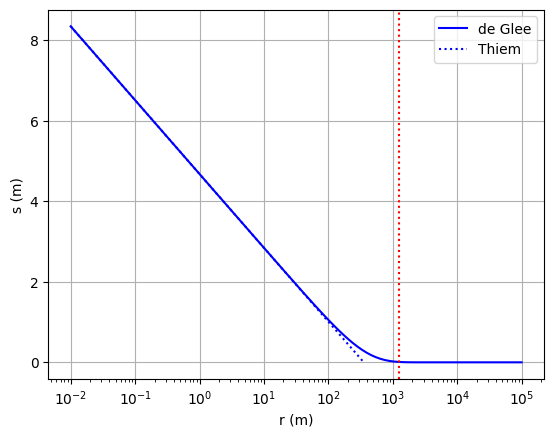

In [23]:
plt.semilogx(r1, h0 - h1, 'b-', label="de Glee");  # drawdown (m) according to de Glee formula
plt.semilogx(r2, h0 - h2, 'b:', label="Thiem");    # drawdown (m) according to Thiem formula
yl = plt.ylim()
plt.semilogx([R2, R2], yl, 'r:')  # radius of influence (m)
plt.ylim(yl);
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.legend();
plt.grid();

## 4. The Theis equation

The Theis equation is used to simulate transient one-dimensional axisymmetric flow to a pumping well in a confined aquifer. It may also be used to simulate flow to a well fully penetrating a phreatic aquifer, under the condition that the drawdown is relatively small compared with the initial saturated thickness of the aquifer.

We import function `theis` from module `maxsypy.special`, and again, we also import function `thiem` because we will approximate the Theis solution by applying the well-known Cooper-Jacob approximation:

In [24]:
from maxsypy.special import theis, thiem

print(inspect.getsource(theis))

def theis(r, t, T, S, Q, h_out=0.0):
    """
    Simulate transient flow to a pumping well in a confined aquifer.
    The well has an infinitesimal radius and extracts water at a constant pumping rate.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    Q : float
      Pumping rate [L³/T] of the well.
    h_out : float, default: 0.0
          Constant head [L] at the outer boundary condition, which is also the initial head in the aquifer.

    Returns
    -------
    h : ndarray
      Hydraulic head [L] at distances `r` and times `t`.
      Shape of `h` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of `t`.
    """
    t, r = np.meshgrid(t, r)
    return h_out + Q / 4 / np.pi / T * exp1(r * r * S / 4 / t / T)



It is interesting to notice that function `theis` uses SciPy function `exp1` which can be imported again from module `scipy.special`. This function implements the exponential integral, which is how the Theis' well function $W$ is called by mathematicians.

Our previous example is used again to show how function `Theis` is used. In this case, we also need the aquifer storativity `S`:

In [25]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)

r1 = np.logspace(-2, 5, 100)  # radial distances (m)
t  = np.logspace(-3, 3, 3)    # simulation times (d)
h1 = theis(r=r1, t=t, Q=Q, T=T, S=S, h_out=h0)  # head (m) according to the Theis equation

Checking the `shape` of head matrix `h1`, it is seen that the number of rows corresponds to the number of distances `r1` whereas the number of columns corresponds to the number of simulation times `t`:

In [26]:
h1.shape

(100, 3)

The Cooper-Jacob approximation says we can approximate the Theis equation by the Thiem equation for small distances `r` and/or large values of time `t`. To do so, we need to estimate the radius of influence, which is time-dependent in this case:

> $R(t) = \sqrt{\dfrac{4tT}{e^{\gamma}S}}$

In [27]:
R1t = [np.sqrt(4*t*T/S/np.exp(np.euler_gamma)) for t in t]  # list comprehension calculating R(t) for each time t

h2, r2 = [], []
for R1 in R1t:
    r2.append(np.logspace(-2, np.log10(R1), 100))  # radial distances (m)
    h2.append(thiem(r=r2[-1], Q=Q, T=T, h_out=h0, r_out=R1))  # head (m) according to the Thiem formula

Just like for the de Glee model, there is a safer way to estimate the radius of influence by taking 8 times the diffusivity $T/S$:

In [28]:
R2t = [np.sqrt(8*t*T/S) for t in t]

Let's plot the result:

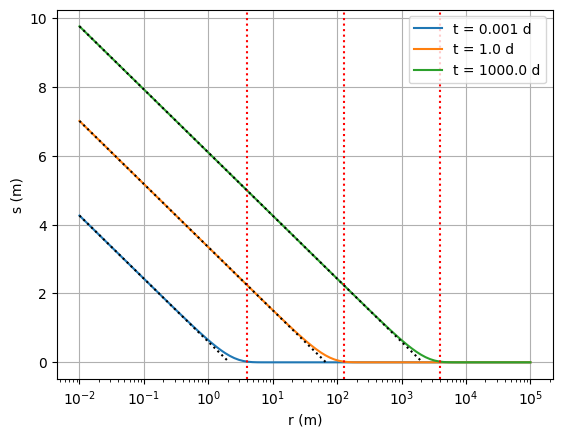

In [29]:
plt.semilogx(r1, h0 - h1, '-');  # drawdown (m) according to the Theis equation
plt.legend(['t = '+ str(t) + ' d' for t in t])
yl = plt.ylim()
for i in range(len(t)):
    plt.semilogx(r2[i], h0 - h2[i], 'k:');  # drawdown (m) according to the Thiem equation
    plt.semilogx([R2t[i], R2t[i]], yl, 'r:');  # radius of influence (m)
plt.ylim(yl);
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.grid();

Instead of using SciPy function `exp1`, it is also possible to numerically invert the Theis solution in the Laplace domain using the Stehfest algorithm. Module `maxsypy.special` contains function `stehfest` that implements this algorithm:

In [30]:
from maxsypy.special import stehfest, stehfest_weights

print(inspect.getsource(stehfest))
print(inspect.getsource(stehfest_weights))

def stehfest(F, t, ns=12):
    """
    Stehfest algorithm for numerical inversion of Laplace transforms.

    Parameters
    ----------
    F : callable
      Function that calculates the Laplace transform. It has frequency parameter `p` [1/T] as input
      and returns the Laplace-transform `F(p)`. Input parameter `p` is a one-dimensional numpy array,
      and the returned output is also a one-dimensional numpy array with the same length as `p`.
    t : array_like
      One-dimensional array with the real times `t` [T].
    ns : int, default: 12
       Number of terms considered in the Stehfest algorithm applied for the inversion of the Laplace solution.
       Must be a positive, even integer.

    Returns
    -------
    f : ndarray
      One-dimensional array with the numerically inverted values `f(t)`. The length of `f` equals the length of `t`.
    """
    t = np.array(t)
    if t.ndim == 0:
        t = t[np.newaxis]
    nt = len(t)
    ns = int(ns)
    ln2t = log(2) / t
    W =

The Laplace solution uses the zero order modified Bessel function of the second kind $K_0$, which is imported from module `scipy.special`:

In [31]:
from scipy.special import k0

We see the numerically inverted Laplace solution is virtually the same indeed as the solution that uses the exponential integral:

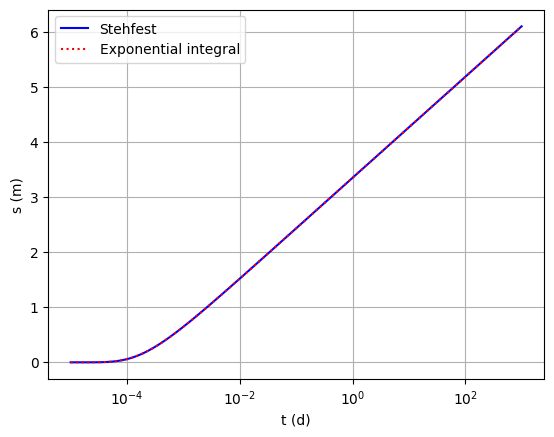

In [32]:
r = 1  # radial distance (m)
t = np.logspace(-5, 3, 100)  # simulation times (d)

sp = lambda p: -Q / 2 / np.pi / T / p * k0(r * np.sqrt(S * p / T))  # Laplace solution
s1 = stehfest(sp, t)  # numerical inversion of Laplace solution

s2 = theis(r=r, t=t, Q=-Q, T=T, S=S)  # solution that applies exp1 function

plt.semilogx(t, s1, 'b-', t, s2.T, 'r:');
plt.legend(['Stehfest', 'Exponential integral']);
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

## 5. The Hantush-Jacob model

The Hantush-Jacob solution is used to simulate transient one-dimensional axisymmetric flow to a pumping well in a leaky aquifer.

The Hantush-Jacob solution is implemented in function `hantush_jacob`. Because this solution is asymptotical to the Theis and the de Glee solutions, we also import functions `theis` and `deglee` so we can compare them.

When we inspect the code of function `hantush_jacob`, we see there are two possible solution methods:

1. the numerical inversion of the Laplace solution using the Stehfest algorihtm;
2. a fast numerical approximation of the Hantush well function $W$.

In [33]:
from maxsypy.special import hantush_jacob, theis, deglee

print(inspect.getsource(hantush_jacob))

def hantush_jacob(r, t, T, S, Q, c_top, h_top=0.0, ns=12):
    """
    Simulate transient flow to a pumping well in a leaky aquifer.
    The well has an infinitesimal radius and extracts water at a constant pumping rate.

    The solution is obtained from numerical inversion of the exact analytical solution in Laplace space.
    There is also the option to apply a fast approximation of the Hantush Well function W.
    See input parameter `ns`.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    Q : float
      Pumping rate [L³/T] of the well.
    c_top : float
          Vertical resistance [T] of the aquitard overlying the aquifer.
    h_top : float, default: 0.0
          Constant head [L] of the upper boundary condition, which is also the initial head i

We return to our example to show that the Hantush-Jacob solution can be approximated by the Theis equation for small values of time and that it is virtually the same as the de Glee solution once the flow is in a steady state:

In [34]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
c  = 500     # aquitard resistance (d)
S  = 0.1     # aquifer storativity (-)

r  = np.logspace(-1, 2, 4)    # radial distances (m)
t  = np.logspace(-5, 5, 100)  # simulation times (d)
h1 = hantush_jacob(r=r, t=t, Q=Q, T=T, S=S, c_top=c, h_top=h0)  # head (m) according to Hantush-Jacob
h2 = theis(r=r, t=t, Q=Q, T=T, S=S, h_out=h0)  # head (m) according to Theis
h3 = deglee(r=r, Q=Q, T=T, c_top=c, h_top=h0)  # head (m) according to de Glee

Plotting the result:

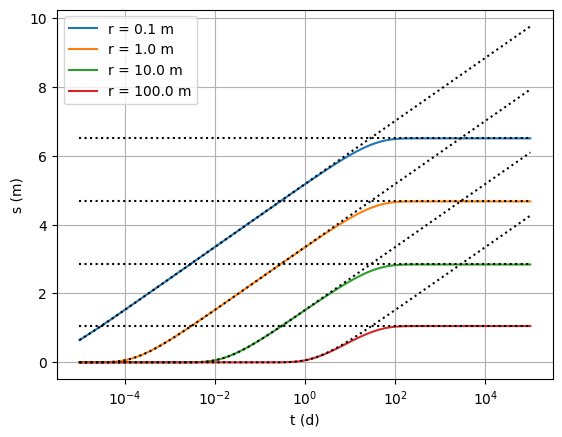

In [35]:
plt.semilogx(t, h0 - h1.T, '-');  # drawdown (m) according to Hantush-Jacob
plt.legend(['r = '+ str(r) + ' m' for r in r])
plt.semilogx(t, h0 - h2.T, 'k:');  # drawdown (m) according to Theis
plt.semilogx(t[[0, -1]], np.tile(h0 - h3, (2, 1)), 'k:');  # drawdown (m) according to de Glee
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

## 6. The Ernst model

The Ernst solution is used to simulate steady one-dimensional axisymmetric flow to a pumping well in a phreatic aquifer subject to uniform areal recharge and nonlinear drainage. Although the aquifer is phreatic, its transmissivity is constant.

The Ernst solution is implemented in function `ernst`. Because this solution is asymptotical to the solution of a well extracting a circular island with recharge and to the de Glee solution, we also import functions `bredehoeft` and `deglee` so we can compare them. The function `bredehoeft` is named after the hydrogeologist John Bredehoeft who used the circular island example in his papers debunking the water budget myth. The solution is found by superimposing the Thiem equation and the solution of a circular infiltration pond.

In [36]:
from maxsypy.special import ernst, bredehoeft, deglee

We consider the same example as before, and this time we also need to define the infiltration flux `N`. In Belgium, a recharge of 200 mm/y is a realistic value.

In [37]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
N  = 200 / 1000 / 365  # infiltration flux (m/d)
print("N =", N, "m/d")

N = 0.0005479452054794521 m/d


We see that the Ernst solution can be approximated by the combined solution of a circular infiltration pond and the Thiem equation for small values drainage resistance `c`, and that it is virtually the same as the de Glee solution when resistance `c` is large:

R =  762.1781565260303 m


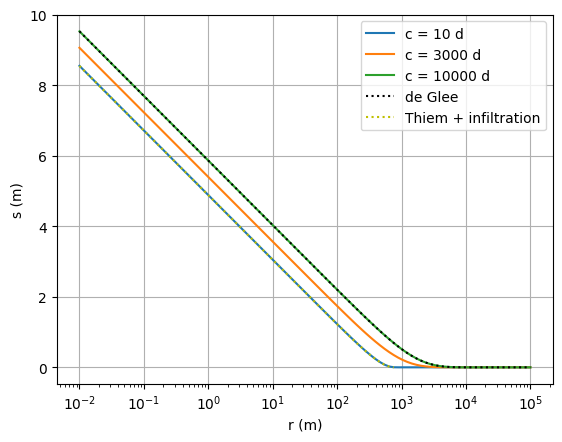

In [38]:
r = np.logspace(-2, 5, 100)  # radial distances (m)

# Ernst
for c in [10, 3000, 10_000]:  # drainage resistances (d)
    s = ernst(r=r, T=T, c=c, N=N, Q=Q)  # drawdown (m)
    plt.semilogx(r, s, '-', label="c = "+ str(c) + " d");

# Approximation for large c: de Glee
s = -deglee(r=r, T=T, c_top=c, Q=Q)  # drawdown (m)
plt.semilogx(r, s, 'k:', label='de Glee');

# Approximation for small c: Thiem + circular infiltration pond
R = np.sqrt(-Q / np.pi / N)  #  radius of influence (m)
print("R = ", R, "m")
s = -bredehoeft(r=r[r<=R], T=T, Q=Q, N=N, r_out=R)  # drawdown (m)
plt.semilogx(r[r<=R], s, 'y:', label='Thiem + infiltration');

plt.legend();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.grid();

## 7. Theis' recovery test

In this section, a recovery test in a confined aquifer is simulated by applying the superposition method to the Theis solution.

We import function `theis_recovery` from module `maxsypy.special`. When we inspect the code, we see it uses function `theis` and it applies superposition in time. First, the pumping is simulated during the entire simulation period, that is during both the pumping and the recovery phase. Then the calculated drawdown for the recovery phase is corrected by superimposing the head change due to a well injecting water at the same rate.

In [39]:
from maxsypy.special import theis_recovery

print(inspect.getsource(theis_recovery))

def theis_recovery(r, t, T, S, Q, t_end, S2=None):
    """
    Simulate pumping followed by recovery in a confined aquifer. The well has an infinitesimal radius and extracts water
    at a constant pumping rate during the pumping phase. The pump is shut down completely at the beginning of the
    recovery phase. The solution is obtained by applying the superposition principle to the Theis equation.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-] during pumping.
    Q : float
      Pumping rate [L³/T] of the well.
    t_end : float
          Time [T] at which the pumping stops and the recovery starts.
    S2 : float, default: None
       Aquifer storativity [-] during recovery. If `S2` is not given, `S2` is set to `S`.

    Returns
    -------
    s : ndarr

Returning to the previous example:

In [40]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)

We simulate the head change in the pumping well with a radius of 0.1 m. The well extracts water from the confined aquifer during 1 day, after which its pump is shut down:

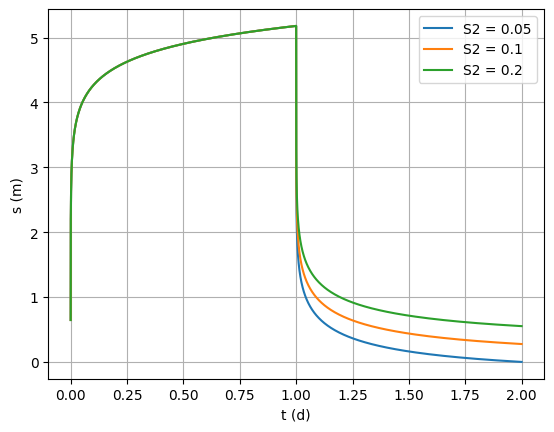

In [41]:
r = 0.1    # radial distance (m)
t_end = 1  # time at which pump is shut down
t = np.logspace(-5, np.log10(t_end), 1000)
t = np.hstack((t, t_end + t))  # simulation times (d)

for S2 in np.array([0.5, 1, 2]) * S:  # storativity (-) during recovery
    s = theis_recovery(r=r, t=t, Q=Q, T=T, S=S, t_end=t_end, S2=S2)  # drawdown (m)
    plt.plot(t, s.squeeze(), '-', label="S2 = " + str(S2));

plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.legend();
plt.grid();

It is possible the aquifer storativity `S2` during recovery is different from the storativity `S` during pumping. That is why additional simulations were performed where `S2` is two times smaller and two times larger than `S`. Although the factor 2 may seem unrealistically large, it is chosen to obtain a clear visual distinction.

## 8. A pumping well close to a river

By applying the method of images, it is possible to simulate flow to a pumping well close to a straight river with constant water level. We illustrate the method by applying it to the Theis equation:

In [42]:
from maxsypy.special import theis

We take the same example as before, and additionally, we define a north-south oriented river that is L = 100 m away from the pumping well.

In [43]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)
L  = 100     # horizontal distance (m) between well and rivier

The well is at position (0, 0), and if the river is located on the left of the well, then we need to define an image well at position (-2L, 0) that injects water at the same rate -Q. Superimposing the head changes of both the pumping well and the imaginary injection well creates a constant-head boundary that coincides with the river:

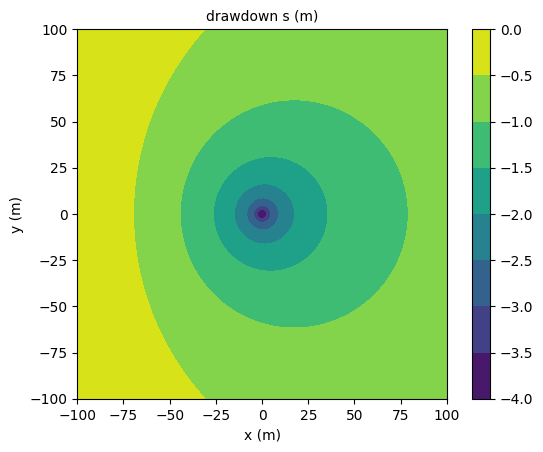

In [44]:
# applying the method of images

t = 1e3  # time (d)
x_pump, y_pump = 0, 0  # pumping well coordinates: (0, 0)
x_im, y_im = -2*L, 0   # image injection well coordinates: (-2L, 0)

x = y = np.linspace(-L, L, 100)     # x and y coordinates (m)
x_grid, y_grid = np.meshgrid(x, y)  # grid coordinates

r_pump = np.sqrt((x_grid - x_pump)**2 + (y_grid - y_pump)**2)  # distances (m) to pumping well
s_pump = theis(r=r_pump.flatten(), t=t, T=T, S=S, Q=Q);  # drawdown (m) due to pumping

r_im = np.sqrt((x_grid - x_im)**2 + (y_grid - y_im)**2)  # distances (m) to injection well
s_im = theis(r=r_im.flatten(), t=t, T=T, S=S, Q=-Q);  # head change (m) due to injection

plt.contourf(x_grid, y_grid, np.reshape(s_pump + s_im, x_grid.shape));
plt.colorbar()
plt.gca().set_aspect('equal');
plt.xlabel('x (m)');
plt.ylabel('y (m)');
plt.title('drawdown s (m)', fontdict=dict(fontsize=10));

Recall that the radial distance $r$ between the well $(x_w, y_w)$ and a grid node $(x,y)$ is determined by the Euclidean distance between both points:

> $r = \sqrt{(x-x_w)^2 + (y-y_w)^2}$

The method of images can also be applied to simulate the effect of an impervious lateral boundary close to to the well. In this case, an image well extracting at the same pumping rate is used instead of an imaginary injection well.

As we already know, the Theis equation may be approximated by the Thiem equation for large values of time. The question that comes into mind here is which value for the radius of influence `R` do we have to choose? As the pumping and the injection are balanced, the value for `R` doesn't matter as long as it is sufficiently large:

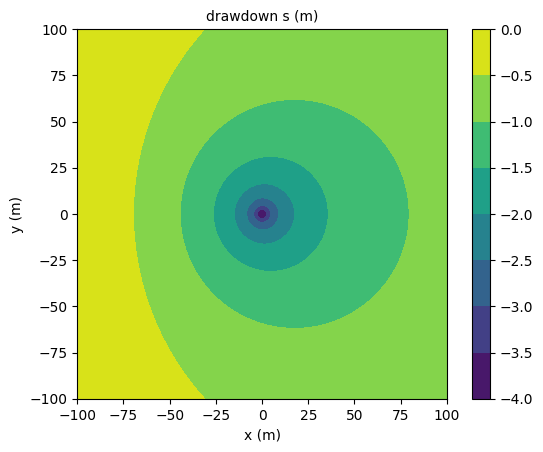

In [45]:
from maxsypy.special import thiem

R = 1e6  # setting R to a very large value
s_pump = thiem(r=r_pump.flatten(), T=T, Q=Q, r_out=R);  # drawdown (m) due to pumping
s_im = thiem(r=r_im.flatten(), T=T, Q=-Q, r_out=R);  # head change (m) due to injection

plt.contourf(x_grid, y_grid, np.reshape(s_pump + s_im, x_grid.shape));
plt.colorbar()
plt.gca().set_aspect('equal');
plt.xlabel('x (m)');
plt.ylabel('y (m)');
plt.title('drawdown s (m)', fontdict=dict(fontsize=10));

As expected, we get the same contour plot as before!

## 9. The Cooper et al. model

To simulate a slug test in a confined aquifer, the Cooper et al. method may be used, which is implemented in function `cooper`:

In [46]:
from maxsypy.special import cooper

print(inspect.getsource(cooper))

def cooper(rc, rw, H0, T, S, t, r=None, ns=12):
    """
    Simulate a slug test conducted in a finite-diameter well fully penetrating a confined aquifer.

    The function applies the Stehfest algorithm to numerically invert the Laplace transform.

    Parameters
    ----------
    rc : float
       Radius [L] of the well-casing.
    rw : float
       Radius [L] of the well-screen.
    H0 : float
       Initial and instantaneous head change [L] in the well.
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-].
    t : array_like
      One-dimensional array with the simulation times [T].
    r : array_like, default: `None`
      Radial distances [L]. If `None`, head change in the well is simulated.
    ns : int, default: `12`
       Number of Stehfest parameters

    Returns
    -------
    s : ndarray
      Head change [L] at distances `r` and times `t`.
      The shape of `s` is `(nr, nt)`, with `nr` the length of `r`, and `nt` the length of 

We see that the function applies the Stehfest algorithm to numerically invert the solution in Laplace space. Besides calculating the head change in the tested well, it is also possible to simulate the head change in an observation well.

If we adopt the example from previous sections, we need to define an initial head change `H0` in the tested well instead of a constant pumping rate. Additionally, we also need the radius of the well-screen `rw` and the radius of the well-casing `rc`. The latter is used to take into account the change in wellbore storage.

In [47]:
H0 = 0.5     # initial head change (m) in the well
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)
rw = 0.05    # well-screen radius (m)
rc = 0.1     # well-casing radius (m)

Let's simulate a slug test in the well and plot the head change in this well and in an observation well at 1 m from the tested well:

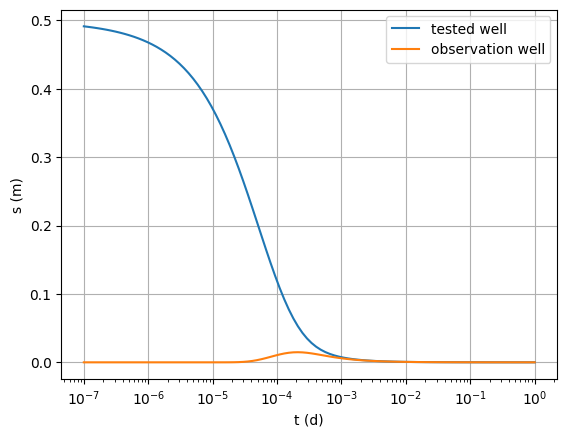

In [48]:
t = np.logspace(-7, 0, 100)  # simulation times (d)
sw = cooper(rc=rc, rw=rw, H0=H0, T=T, S=S, t=t)  # head change (m) in the well
s  = cooper(rc=rc, rw=rw, H0=H0, T=T, S=S, t=t, r=1)  # head change (m) in observation well at 1 m

plt.semilogx(t, sw.squeeze(), label="tested well");
plt.semilogx(t, s.squeeze(), label="observation well");
plt.legend();
plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.grid();

The effect of the slug test is almost not visible anymore in the observation well.

## 10. The Butler model

The Butler model extends the Theis solution by allowing for a finite-thickness skin surrounding the well-screen.

We import function `butler` and function `theis` as we will compare the first with the latter:

In [49]:
from maxsypy.special import butler, theis

Again, we consider the following example, and this time we also need the well radius `rw` and the radius of the skin `Rs`:

In [50]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)
rw = 0.05    # well-screen radius (m)
Rs = 0.5     # well-skin radius (m)

First, let's simulate a *positive skin effect* by assigning a transmissivity `Ts` to the skin zone which is two times smaller than the aquifer transmissivity `T`. The exact solution is given by Butler's model, while an approximate solution is obtained by applying the Theis equation and the dimensionless skin factor $F$:

> $F = \dfrac{T}{T_s}\ln\dfrac{r_w}{R_s}$

The drawdown in the well $s_w$ is approximated as follows:

> $s_w(t) \approx s(R_s,t) + \dfrac{Q}{2 \pi T} F$

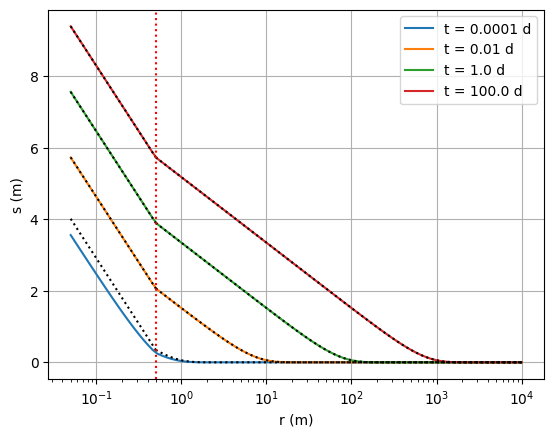

In [51]:
# positive skin effect: skin is less pervious

Ts = T / 2   # well-skin transmissivity (m²/d)

t = np.logspace(-4, 2, 4)  # simulation times (d)
r = np.logspace(np.log10(rw), 4, 100)  # radial distances (m)
s = butler(r=r, t=t, R=Rs, T=[Ts, T], S=[S, S], Q=Q)  # drawdown (m) according to Butler
plt.semilogx(r, s);
plt.legend(['t = ' + str(t) + " d" for t in t]);

r = np.logspace(np.log10(Rs), 4, 100)  # radial distances (m)
s = -theis(r=r, t=t, T=T, S=S, Q=Q)  # drawdown (m) according to Theis
plt.semilogx(r, s, 'k:');

F = T / Ts * np.log(rw / Rs)  # dimensionless skin factor
sw = s[0, :] + Q / 2 / np.pi / T * F  # drawdown (m) in the well
plt.semilogx([rw, Rs], np.vstack((sw, s[0, :])), 'k:');

yl = plt.ylim()
plt.semilogx([Rs, Rs], yl, 'r:');  # skin radius (m)
plt.ylim(yl);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

We see the approximation that uses the Thiem equation and the dimensionless skin factor is virtually the same as the exact solution for large values of time.

Let's simulate the opposite case where the skin transmissivity `Ts` is two times the aquifer transmissivity `T`, which results in a *negative skin effect*:

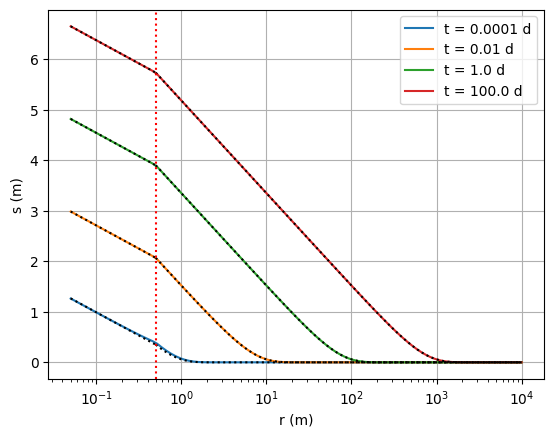

In [52]:
# negative skin effect: skin is more permeable

Ts = T * 2   # well-skin transmissivity (m²/d)

t = np.logspace(-4, 2, 4)  # simulation times (d)
r = np.logspace(np.log10(rw), 4, 100)  # radial distances (m)
s = butler(r=r, t=t, R=Rs, T=[Ts, T], S=[S, S], Q=Q)  # drawdown (m) according to Butler
plt.semilogx(r, s);
plt.legend(['t = ' + str(t) + " d" for t in t]);

r = np.logspace(np.log10(Rs), 4, 100)  # radial distances (m)
s = -theis(r=r, t=t, T=T, S=S, Q=Q)  # drawdown (m) according to Theis
plt.semilogx(r, s, 'k:');

F = T / Ts * np.log(rw / Rs)  # dimensionless skin factor
sw = s[0, :] + Q / 2 / np.pi / T * F  # drawdown (m) in the well
plt.semilogx([rw, Rs], np.vstack((sw, s[0, :])), 'k:');

yl = plt.ylim()
plt.semilogx([Rs, Rs], yl, 'r:');  # skin radius (m)
plt.ylim(yl);
plt.grid();
plt.xlabel('r (m)');
plt.ylabel('s (m)');

The negative skin effect is less pronounced, and as a result, the exact and the approximate solutions coincide for all simulation times.

## 11. The Hemker solutions

In previous sections, specific axisymmetric models were illustrated. The solutions of these models are available from module `maxsypy.special`.

The generalized multilayer solutions for steady and transient multilayer flow developed by Hemker are implemented respectively in classes `Steady` and `Transient`, and can be imported from module `maxsypy.multilayer`:

In [53]:
from maxsypy.multilayer import Steady, Transient

Let's illustrate the use of these classes by constructing the following three-layer model:

In [54]:
T = [100, 200, 50]            # aquifer transmissivities (m²/d)
S = [0.1, 0.05, 0.01]         # aquifer storativities (-)
c = [100, 500, 1000, np.inf]  # aquitard resistances (d)
Q = [-100, -250, 0]           # pumping rates (m³/d)

The steady-state and transient-state are instantiated as follows:

In [55]:
model1 = Steady(T=T, Q=Q, c_top=c[0], c=c[1:-1], c_bot=c[-1])
model2 = Transient(T=T, S=S, Q=Q, c_top=c[0], c=c[1:-1], c_bot=c[-1])

Head or drawdown is simulated by invoking method `h` on these model objects. In case of a steady-state model, only distances `r` are passed:

> `s1 = model1.h(r)`

The transient-state model also needs times `t`:

> `s2 = model2.h(r, t)`

Let's illustrate the use of these methods by creating the time-drawdown and the distance-drawdown graphs for this example:

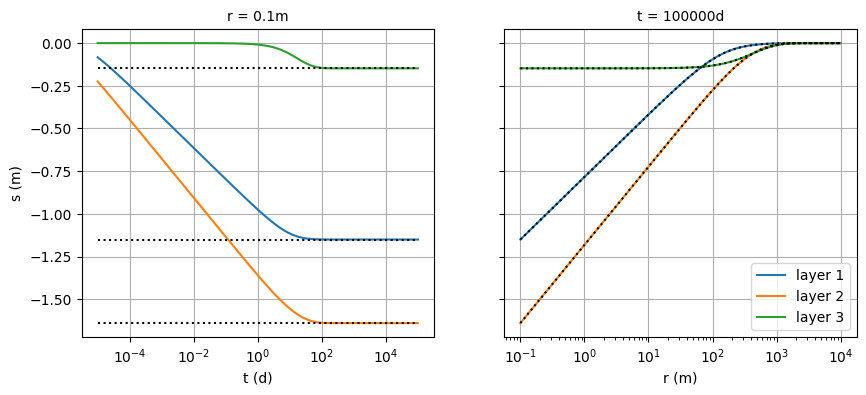

In [56]:
r = np.logspace(-1, 4, 100)  # radial distances (m)
t = np.logspace(-5, 5, 100)  # simulation times (d)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True);

ax1.semilogx(t, model2.h(r[0], t).squeeze().T);  # transient drawdown (m)
ax1.semilogx(t[[0, -1]], model1.h([r[0], r[0]]).T, 'k:');  # steady-state drawdown (m)
ax1.set_ylabel('s (m)');
ax1.set_xlabel('t (d)');
ax1.set_title('r = ' + str(r[0]) + 'm', fontdict=dict(size=10));
ax1.grid();

ax2.semilogx(r, model2.h(r, t[-1]).squeeze().T);  # transient drawdown (m)
ax2.semilogx(r, model1.h(r).T, 'k:');  # steady-state drawdown (m)
ax2.legend([f'layer {i+1}' for i in range(model1.nl)]);
ax2.set_xlabel('r (m)');
ax2.set_title('t = ' + str(int(t[-1])) + 'd', fontdict=dict(size=10));
ax2.grid();

We see that that steady state is reached after approximately 100 days of pumping.

Note that the same classes can be use to simulate parallel flow in a multilayer aquifer system. As an example, consider a river with a half-width of 10 m in which the water level is increased by 1 m:

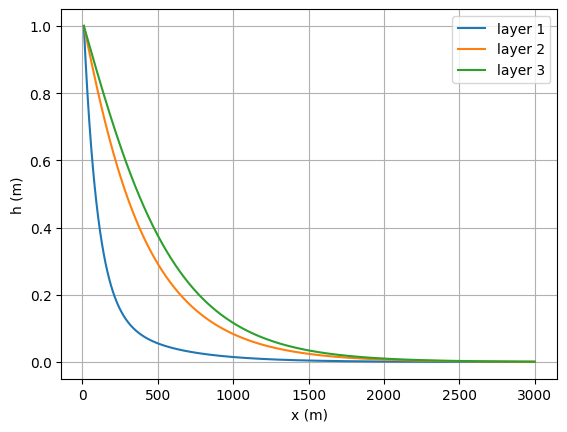

In [57]:
river = Steady(T=T, c_top=c[0], c=c[1:-1], c_bot=c[-1],  # hydraulic parameters
               r_in=10,         # half-width of the river is 10 m
               h_in=[1, 1, 1],  # instead of pumping rate Q, a constant head h_in equal to 1 m is defined
               axi=False)       # by default axi is True, but in case of parallel flow, it is set to False

x = np.linspace(river.r_in, 3000, 1000)  # horizontal distances (m)
h = river.h(x)  # head change (m)

plt.plot(x, h.T);
plt.legend([f'layer {i+1}' for i in range(river.nl)]);
plt.xlabel('x (m)');
plt.ylabel('h (m)');
plt.grid();

## 12. A practical case study

In this section we simulate the effect of the drainage system at the excavation site 'Duinenabdij'. The system consists of pumping and injections wells. The total pumping rate equals the total injection rate as all the extracted groundwater is re-injected into the aquifer system. As a consequence, the system will finally reach a steady state. Therefore, we use class `Steady` to simulate the individual head change of each well. The total head change is obtained by summing all individual head changes according to the *superposition principle*.

In [58]:
from maxsypy.multilayer import Steady

The coordinates of the pumping and injection wells.

In [59]:
# pumping wells
pwells = np.array([ [170.61611374, 246.2633452 ],
                    [197.63033175, 237.01067616],
                    [223.93364929, 236.29893238],
                    [248.81516588, 234.87544484],
                    [278.67298578, 237.72241993],
                    [287.91469194, 259.0747331 ],
                    [296.44549763, 286.12099644],
                    [320.61611374, 289.6797153 ],
                    [345.49763033, 294.66192171],
                    [375.35545024, 302.4911032 ],
                    [400.9478673 , 307.47330961],
                    [418.00947867, 276.8683274 ],
                    [398.81516588, 243.41637011],
                    [386.72985782, 217.08185053],
                    [370.37914692, 186.47686833],
                    [351.18483412, 170.81850534],
                    [326.30331754, 155.87188612],
                    [293.60189573, 168.68327402],
                    [270.85308057, 191.45907473],
                    [248.81516588, 187.90035587],
                    [222.51184834, 181.49466192],
                    [199.0521327 , 183.62989324],
                    [181.99052133, 200.        ],
                    [162.79620853, 217.79359431],
                    [409.47867299, 292.17081851],
                    [408.41232227, 260.14234875] ])

In [60]:
# injection wells
iwells = np.array([ [106.63507109, 261.20996441],
                    [120.14218009, 272.59786477],
                    [138.62559242, 292.52669039],
                    [145.73459716, 306.76156584],
                    [161.37440758, 318.86120996],
                    [179.85781991, 326.69039146],
                    [193.36492891, 338.79003559],
                    [212.55924171, 346.61921708],
                    [231.04265403, 355.87188612],
                    [248.1042654 , 362.27758007],
                    [260.18957346, 368.68327402],
                    [272.98578199, 381.49466192],
                    [290.04739336, 388.61209964],
                    [310.66350711, 397.86476868],
                    [330.56872038, 412.8113879 ],
                    [352.60663507, 427.75800712],
                    [375.35545024, 425.6227758 ],
                    [393.12796209, 417.08185053],
                    [411.61137441, 417.08185053],
                    [429.38388626, 423.48754448],
                    [450.        , 423.48754448],
                    [477.72511848, 417.08185053],
                    [491.23222749, 397.86476868],
                    [463.86255924, 420.28469751] ])

Plotting the wells:

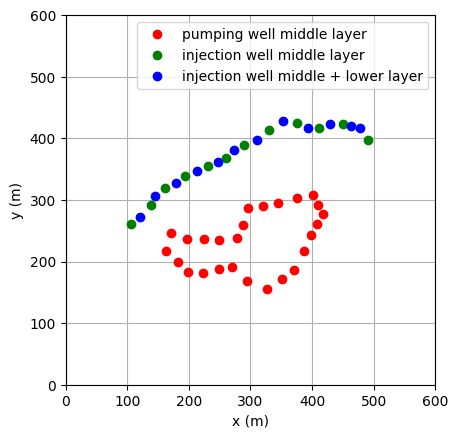

In [61]:
plt.plot(pwells[:, 0], pwells[:, 1], 'ro', label='pumping well middle layer');
plt.plot(iwells[::2, 0], iwells[::2, 1], 'go', label='injection well middle layer');
plt.plot(iwells[1::2, 0], iwells[1::2, 1], 'bo', label='injection well middle + lower layer');

plt.xlabel('x (m)');
plt.ylabel('y (m)');
lim = (0, 600)
plt.xlim(lim);
plt.ylim(lim);
plt.grid();
plt.gca().set_aspect('equal', 'box');
plt.legend();

The original pumping and injection rates (m³/d):

In [62]:
# pumping and injection rates
npw, niw = len(pwells), len(iwells)
print(f"{npw} pumping wells")
print(f"{niw} injection wells")
Q_grav = 4.0  # P1: discharge through gravel pack surrounding the pumping wells (upper layer)
Q_pump = 60.0  # P2: pumping rate (middle layer)
Q_deep = -40.0  # P4: deep injection rate (lower layer)
Q_inj = -(npw * (Q_pump + Q_grav) + niw / 2 * Q_deep) / niw  # P3: injection rate (middle layer)
print(f"gravel pack discharge (upper layer): {Q_grav:.2f} m³/d")
print(f"pumping rate (middle layer): {Q_pump:.2f} m³/d")
print(f"injection rate (middle layer): {Q_inj:.2f} m³/d")
print(f"injection rate (lower layer): {Q_deep:.2f} m³/d")

26 pumping wells
24 injection wells
gravel pack discharge (upper layer): 4.00 m³/d
pumping rate (middle layer): 60.00 m³/d
injection rate (middle layer): -49.33 m³/d
injection rate (lower layer): -40.00 m³/d


The aquifer system consists of three permeable layers separated by two semi-pervious layers. As we assume the flow is in a steady state, the latter can be conceptualized as incompressible zero-thickness resistance layers:

In [63]:
# transmissivities T (m²/d) and resistances c (d)
T = [2.9 * 12, 5.2 * 13.8, 10.7 * 42.0]  # T = D * Kh
c = [1300.0, 49.70]  # confined system

Creating the superposition grid:

In [64]:
# 600m x 600m meshgrid
n = 100
coord = np.linspace(0, 600, n)
xgrid, ygrid = np.meshgrid(coord, coord)

Defining function `euclidean` to calculate Euclidean distance between two points:

In [65]:
euclidean = lambda x1, y1, x2, y2: np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

As the aquifer system is confined and steady flow is simulated, the system cannot be laterally unbounded. Therefore we need to define a point at a very large distance at which drawdown is zero. This is a constant-head boundary that will determine the outer model boundary of each axisymmetric model that will be used to simulate the head change due to the individual wells. Because extraction and injection are balanced and the point is at very large distance, this boundary condition will have no significant impact on the total head change.

In [66]:
# constant-head point (x0, y0) at very large distance
x0, y0 = 1e5, 1e5

Finally, we are ready to apply the superposition method:

In [67]:
# initializing the drawdown array
s = np.zeros((len(T), n, n))

# calculate drawdown due to each pumping well
for xy in pwells:
    x, y = tuple(xy)
    r_out = euclidean(x, y, x0, y0)  # determine the outer model boundary using (x0, y0)
    model = Steady(T=T, c=c, Q=[Q_grav, Q_pump, 0], r_out=r_out)
    r = euclidean(x, y, xgrid, ygrid)
    s += model.h(r=r.flatten()).reshape(s.shape)

# calculate the head change due to each injection well
for i, xy in enumerate(iwells):
    x, y = tuple(xy)
    r_out = euclidean(x, y, x0, y0)
    Q3 = Q_deep if i%2 else 0.0  # only half of the injection wells recharge the lower aquifer
    model = Steady(T=T, c=c, Q=[0, Q_inj, Q3], r_out=r_out)
    r = euclidean(x, y, xgrid, ygrid)
    s += model.h(r=r.flatten()).reshape(s.shape)

Plotting the result:

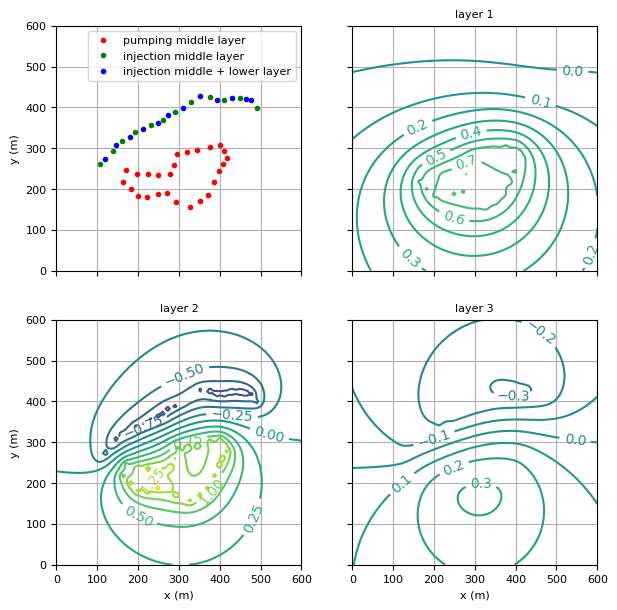

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True);

lim = (0, 600)
d = 100
fontsize = 8

ax[0][0].plot(pwells[:, 0], pwells[:, 1], 'r.', label='pumping middle layer');
ax[0][0].plot(iwells[::2, 0], iwells[::2, 1], 'g.', label='injection middle layer');
ax[0][0].plot(iwells[1::2, 0], iwells[1::2, 1], 'b.', label='injection middle + lower layer');
ax[0][0].set_xlim(lim);
ax[0][0].set_ylim(lim);
ax[0][0].set_aspect('equal', 'box');
ax[0][0].grid();

for i, a in enumerate([ax[0][1], ax[1][0], ax[1][1]]):
    step = 0.25 if i == 1 else 0.1
    cs = a.contour(xgrid, ygrid, s[i, :, :], levels=np.arange(-2, 2, step))
    a.clabel(cs, cs.levels, inline=True);
    a.set_title('layer ' + str(i+1), fontsize=fontsize);
    a.set_xlim(lim);
    a.set_ylim(lim);
    a.set_aspect('equal', 'box');
    a.grid()

ax[0][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[0][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_yticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_yticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][0].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][0].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[1][1].set_xticks(np.arange(lim[0], lim[1] + d, d));
ax[1][1].set_xticklabels(np.arange(lim[0], lim[1] + d, d), fontsize=fontsize);
ax[0][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_ylabel('y (m)', fontsize=fontsize);
ax[1][0].set_xlabel('x (m)', fontsize=fontsize);
ax[1][1].set_xlabel('x (m)', fontsize=fontsize);
ax[0][0].legend(fontsize=fontsize);

## Reference

Louwyck, A., 2023. Axisymmetric Flow in Multilayer Aquifer Systems: Solutions and Theoretical Considerations. PhD thesis, Laboratory for Applied Geology and Hydrogeology, Department of Geology, Ghent University, Belgium. Online available at https://github.com/alouwyck/PhD.

---